In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')

import numpy as np
import matplotlib.pyplot as plt
import quantities as pq
from operator import itemgetter
from edog.tools import*
from edog.plot import*
plt.style.use('seaborn')
plt.rcParams.update(edog.plot.params)

filename = "params.yaml"
params = parse_parameters(filename)

nt, nr, dt, dr = itemgetter("nt", "nr", "dt", "dr")(params["grid"])
k_id, w_id, patch_diameter = itemgetter("k_id", "w_id", "patch_diameter")(params["stimulus"])
A_g, a_g, B_g, b_g = itemgetter("A", "a", "B", "b")(params["ganglion"])
w_rg, A_rg, a_rg = itemgetter("w", "A", "a")(params["relay"]["Krg"])
w_rig, A_rig, a_rig = itemgetter("w", "A", "a")(params["relay"]["Krig"])
w_rc_ex, A_rc_ex, a_rc_ex = itemgetter("w", "A", "a")(params["relay"]["Krc_ex"])
w_rc_in, A_rc_in, a_rc_in = itemgetter("w", "A", "a")(params["relay"]["Krc_in"])

w_rc_mix = itemgetter("w")(params["relay"]["Krc_mix"])
A_rc_mix_in, a_rc_mix_in = itemgetter("A", "a")(params["relay"]["Krc_mix"]["Krc_in"])
A_rc_mix_ex, a_rc_mix_ex = itemgetter("A", "a")(params["relay"]["Krc_mix"]["Krc_ex"])

wavenumber_tuning = {"fb_ex": {}, "fb_in": {}, "fb_mix": {}}

## Feedback excitation

In [2]:
for d in patch_diameter:
    tuning_curve = np.zeros([len(w_rc_ex), len(k_id)])

    for i, w in enumerate(w_rc_ex):
        network = create_spatial_network(nt=nt, nr=nr, dt=dt, dr=dr,
                                 A_g=A_g, a_g=a_g, B_g=B_g, b_g=b_g,
                                 w_rg=w_rg, A_rg=A_rg, a_rg=a_rg,
                                 w_rig=w_rig, A_rig=A_rig, a_rig=a_rig,
                                 w_rc_ex=w, A_rc_ex=A_rc_ex, a_rc_ex=a_rc_ex)

        angular_freq = network.integrator.temporal_angular_freqs[int(w_id)]
        wavenumber = network.integrator.spatial_angular_freqs[k_id.astype(int)]
        spatiotemporal_tuning = spatiotemporal_wavenumber_tuning(network=network,
                                                                 angular_freq=angular_freq,
                                                                 wavenumber=wavenumber,
                                                                 patch_diameter=d)
    
        tuning_curve[i, :] = spatiotemporal_tuning[0, :]
    
    wavenumber_tuning["fb_ex"][float(d.magnitude)] = tuning_curve

## Feedback inhibition

In [3]:
for d in patch_diameter:
    tuning_curve = np.zeros([len(w_rc_in), len(k_id)])
    
    for i, w in enumerate(w_rc_in):
        network = create_spatial_network(nt=nt, nr=nr, dt=dt, dr=dr,
                                 A_g=A_g, a_g=a_g, B_g=B_g, b_g=b_g,
                                 w_rg=w_rg, A_rg=A_rg, a_rg=a_rg,
                                 w_rig=w_rig, A_rig=A_rig, a_rig=a_rig,
                                 w_rc_in=w, A_rc_in=A_rc_in, a_rc_in=a_rc_in)

        angular_freq = network.integrator.temporal_angular_freqs[int(w_id)]
        wavenumber = network.integrator.spatial_angular_freqs[k_id.astype(int)]
        spatiotemporal_tuning = spatiotemporal_wavenumber_tuning(network=network,
                                                                 angular_freq=angular_freq,
                                                                 wavenumber=wavenumber,
                                                                 patch_diameter=d)
    
        tuning_curve[i, :] = spatiotemporal_tuning[0, :]
        
    wavenumber_tuning["fb_in"][float(d.magnitude)] = tuning_curve

## Mixed excitatory and inhibitory feedback

In [4]:
for d in patch_diameter:
    tuning_curve = np.zeros([len(w_rc_mix), len(k_id)])
    
    for i, w in enumerate(w_rc_mix):
        network = create_spatial_network(nt=nt, nr=nr, dt=dt, dr=dr,
                                 A_g=A_g, a_g=a_g, B_g=B_g, b_g=b_g,
                                 w_rg=w_rg, A_rg=A_rg, a_rg=a_rg,
                                 w_rig=w_rig, A_rig=A_rig, a_rig=a_rig,
                                 w_rc_in=w, A_rc_in=A_rc_mix_in, a_rc_in=a_rc_mix_in,
                                 w_rc_ex=w, A_rc_ex=A_rc_mix_ex, a_rc_ex=a_rc_mix_ex)
        angular_freq = network.integrator.temporal_angular_freqs[int(w_id)]
        wavenumber = network.integrator.spatial_angular_freqs[k_id.astype(int)]
        spatiotemporal_tuning = spatiotemporal_wavenumber_tuning(network=network,
                                                                 angular_freq=angular_freq,
                                                                 wavenumber=wavenumber,
                                                                 patch_diameter=d)

        tuning_curve[i, :] = spatiotemporal_tuning[0, :]


    wavenumber_tuning["fb_mix"][float(d.magnitude)] = tuning_curve

-------------
## Plotting

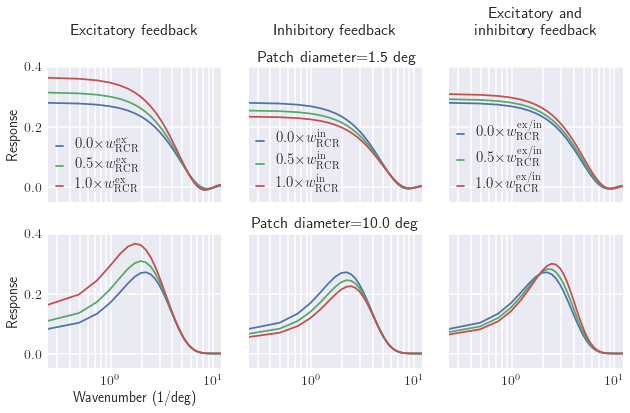

In [6]:
titles = ["Excitatory feedback", "Inhibitory feedback", "Excitatory and\ninhibitory feedback"]
labels = [r"$w^\mathrm{ex}_{\mathrm{RCR}}$", r"$w^\mathrm{in}_{\mathrm{RCR}}$", 
          r"$w^\mathrm{ex/in}_{\mathrm{RCR}}$"]

fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(9, 6), sharey="row", sharex="col")

# small patch size:
for ax, w_rc, curves, title, label in zip([ax1, ax2, ax3],
                                           [w_rc_ex, w_rc_in, w_rc_mix], 
                                           [wavenumber_tuning["fb_ex"][float(patch_diameter[0].magnitude)], 
                                            wavenumber_tuning["fb_in"][float(patch_diameter[0].magnitude)], 
                                            wavenumber_tuning["fb_mix"][float(patch_diameter[0].magnitude)]],
                                           titles, labels):

    for w, curve in zip(w_rc[:], curves[:]):
        ax.plot(wavenumber, curve, '-', label=r"${} \times$".format(round(w, 1))+label)

    ax.set_xlim([0, 12])
    ax.set_ylim([-0.05, 0.4])
    ax.legend(fontsize=15, handlelength=0.5, labelspacing=0.4, borderpad=0.0)
    ax.set_title(title, y=1.2)
    ax.set_xscale("log")
    ax.grid(which="minor", lw=1.5)
    ax.grid(which="major", lw=1.5)
    
    
ax1.set_ylabel("Response")
ax2.set_title(titles[1])
ax2.set_xticklabels([])
ax3.set_xticklabels([])
ax2.text(0.3, 0.42, r"Patch diameter$=${}".format(patch_diameter[0]), fontsize=16)

# large patch size:
for ax, w_rc, curves, title, label in zip([ax4, ax5, ax6],
                                           [w_rc_ex, w_rc_in, w_rc_mix], 
                                           [wavenumber_tuning["fb_ex"][float(patch_diameter[1].magnitude)], 
                                            wavenumber_tuning["fb_in"][float(patch_diameter[1].magnitude)], 
                                            wavenumber_tuning["fb_mix"][float(patch_diameter[1].magnitude)]],
                                           titles, labels):

    for w, curve in zip(w_rc[:], curves[:]):
        ax.plot(wavenumber, curve, '-', label=r"${} \times$".format(round(w, 1))+label)

    ax.set_xlim([0, 12])
    ax.set_ylim([-0.05, 0.4])
    ax.set_xscale("log")
    ax.grid(which="minor", lw=1.5)
    ax.grid(which="major", lw=1.5)
    
ax4.set_ylabel("Response")
ax4.set_xlabel("Wavenumber (1/deg)")
ax5.set_title(r"Patch diameter$=${}".format(patch_diameter[1]))

fig.tight_layout()